# Galaxy10 + CNN, with preprocessing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
BASE = Path().resolve().parent
print(f'BASE: {BASE}')

import torch
torch.manual_seed(0)

IS_MPS_AVAILABLE = torch.backends.mps.is_available() and torch.backends.mps.is_built()
print(f'Is mps avaliable? : {IS_MPS_AVAILABLE}')
if not IS_MPS_AVAILABLE:
    IS_CUDA_AVAILABLE = torch.cuda.is_available()
    print(f'Is cuda avaliable? : {IS_CUDA_AVAILABLE}')
    print(f'cuda device count: {torch.cuda.device_count()}')
    print(f'cuda current device: {torch.cuda.current_device()}')
    print(f'cuda device name: {torch.cuda.get_device_name()}')
    # switch to cuda if available, else mps, else cpu
    DEVICE = torch.device('cuda' if IS_CUDA_AVAILABLE else 'cpu')
    print(f'device: {DEVICE}')

import h5py
from tqdm import tqdm

from sklearn.model_selection import train_test_split

BASE: C:\Users\zheng\Documents\GitHub\SDSSGalCat
Is mps avaliable? : False
Is cuda avaliable? : True
cuda device count: 1
cuda current device: 0
cuda device name: NVIDIA GeForce RTX 4060 Ti
device: cuda


In [2]:
# load data
# data ref: https://astronn.readthedocs.io/en/stable/galaxy10sdss.html

with h5py.File(BASE / 'data/Galaxy10.h5', 'r') as f:
    images = f['images'][:]
    labels = f['ans'][:]

print(f'images.shape: {images.shape}, labels.shape: {labels.shape}')
assert images.shape[0] == labels.shape[0]

images.shape: (21785, 69, 69, 3), labels.shape: (21785,)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


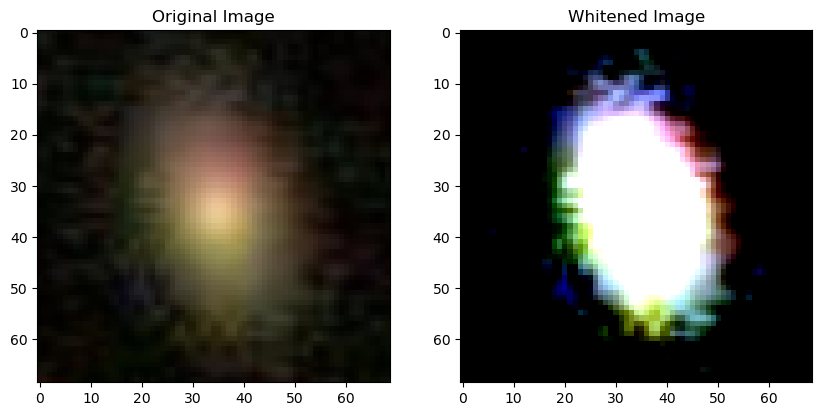

In [3]:
# whiting the image
img_mean = np.mean(images, axis=(1, 2), keepdims=True)
img_std = np.std(images, axis=(1, 2), keepdims=True)
images_white = (images - img_mean) / img_std

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(images[0], cmap='gray')
ax[0].set_title('Original Image')
ax[1].imshow(images_white[0], cmap='gray')
ax[1].set_title('Whitened Image')
plt.show()
plt.close()

images.shape: (87140, 69, 69, 3), labels.shape: (87140,)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


images.shape: (174280, 69, 69, 3), labels.shape: (174280,)


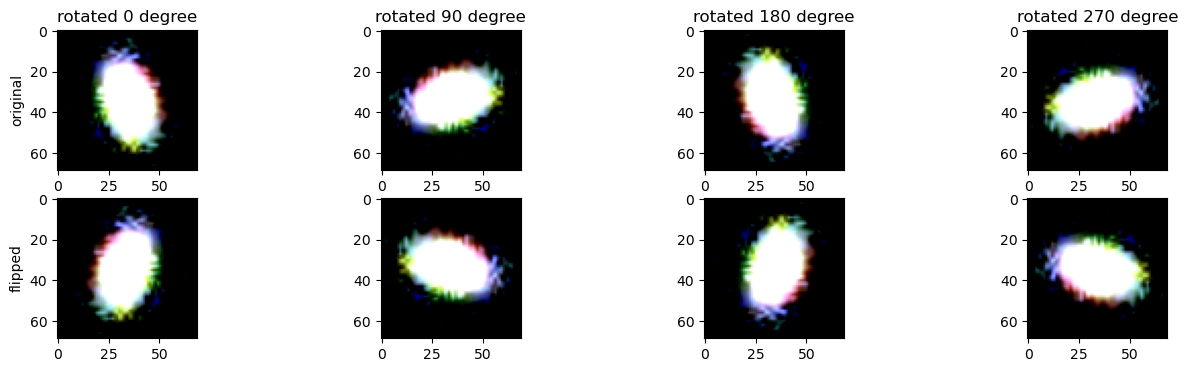

In [4]:
# enlarge the dataset: rotating the images by 90, 180, 270 degrees
images_enlarged = np.concatenate([images_white, np.rot90(images_white, k=1, axes=(1, 2)), np.rot90(images_white, k=2, axes=(1, 2)), np.rot90(images_white, k=3, axes=(1, 2))])
labels_enlarged = np.concatenate([labels, labels, labels, labels])
print(f'images.shape: {images_enlarged.shape}, labels.shape: {labels_enlarged.shape}')

# flip the images horizontally
images_flipped = np.flip(images_enlarged, axis=2)
images_enlarged_flipped = np.concatenate([images_enlarged, images_flipped])
labels_enlarged_flipped = np.concatenate([labels_enlarged, labels_enlarged])
print(f'images.shape: {images_enlarged_flipped.shape}, labels.shape: {labels_enlarged_flipped.shape}')

fig, axs = plt.subplots(2, 4, figsize=(16, 4))
# for i, ax in enumerate(axs):
#     ax.imshow(images_enlarged[i*images.shape[0]], cmap='gray')
#     ax.set_title(f'rotated {i*90} degree')
for i, ax in enumerate(axs[0]):
    ax.imshow(images_enlarged[i*images.shape[0]], cmap='gray')
    ax.set_title(f'rotated {i*90} degree')
    if i == 0:
        ax.set_ylabel('original')
for i, ax in enumerate(axs[1]):
    ax.imshow(images_flipped[i*images.shape[0]], cmap='gray')
    if i == 0:
        ax.set_ylabel('flipped')
plt.show()
plt.close()

del images_white, images_enlarged, labels_enlarged, images_flipped

images.shape: (34928, 69, 69, 3), labels.shape: (34928,)


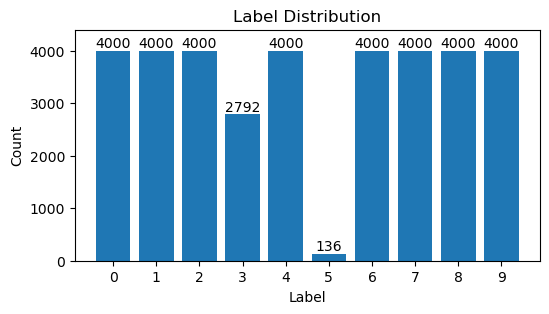

In [5]:
# balance the sample: select at most 1000 samples for each class
np.random.seed(0)
n_samples = 4000
images_balanced = []
labels_balanced = []
for i in range(10):
    if n_samples > np.sum(labels_enlarged_flipped == i):
        images_balanced.append(images_enlarged_flipped[labels_enlarged_flipped == i])
        labels_balanced.append(labels_enlarged_flipped[labels_enlarged_flipped == i])
        continue
    idx = np.where(labels_enlarged_flipped == i)[0]
    idx = np.random.choice(idx, n_samples, replace=False)
    images_balanced.append(images_enlarged_flipped[idx])
    labels_balanced.append(labels_enlarged_flipped[idx])
images_balanced = np.concatenate(images_balanced)
labels_balanced = np.concatenate(labels_balanced)
print(f'images.shape: {images_balanced.shape}, labels.shape: {labels_balanced.shape}')

# show distribution
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.bar(range(10), np.histogram(labels_balanced, bins=10)[0])
ax.set_title('Label Distribution')
ax.set_xlabel('Label')
ax.set_ylabel('Count')
ax.set_xticks(range(10))
for i in range(10):
    ax.text(i, np.sum(labels_balanced == i), f'{np.sum(labels_balanced == i)}', ha='center', va='bottom')
ax.set_ylim(0, 1.1*np.max(np.histogram(labels_balanced, bins=10)[0]))
plt.show()
plt.close()

In [6]:
# split the data, 90% for training and 10% for testing
# make sure that there are equal number of samples for each class in the training and testing set
X_train, X_test, y_train, y_test = train_test_split(images_balanced, labels_balanced, test_size=0.1, stratify=labels_balanced, random_state=0)
print(f'X_train.shape: {X_train.shape}, y_train.shape: {y_train.shape}')
print(f'X_test.shape: {X_test.shape}, y_test.shape: {y_test.shape}')

del images_enlarged_flipped, labels_enlarged_flipped

X_train.shape: (31435, 69, 69, 3), y_train.shape: (31435,)
X_test.shape: (3493, 69, 69, 3), y_test.shape: (3493,)


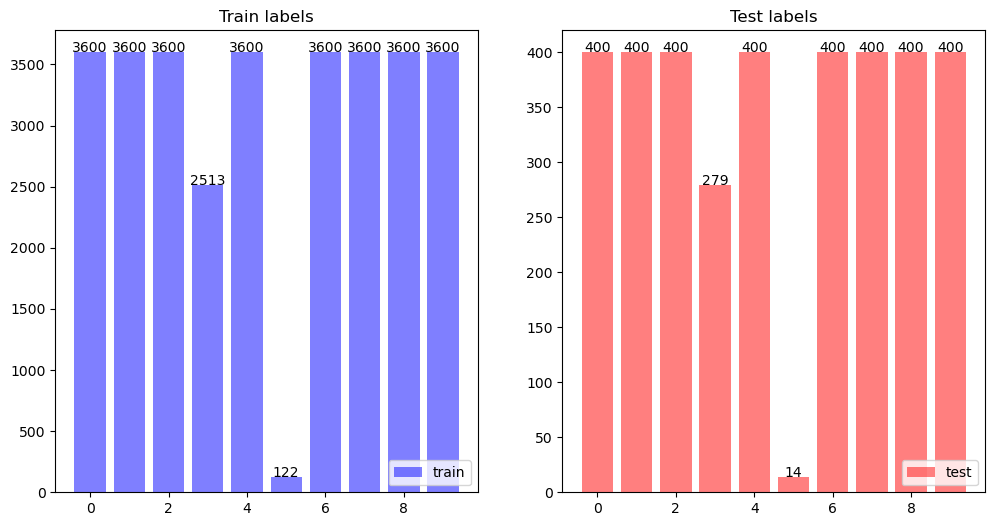

In [7]:
# visualize the splited data
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].bar(range(10), np.histogram(y_train, bins=10)[0], color='blue', alpha=0.5, label='train')
for i in range(10):
    ax[0].text(i, y_train.tolist().count(i), str(y_train.tolist().count(i)), color='black', ha='center')
ax[0].set_title('Train labels')
ax[0].legend(loc='lower right')

ax[1].bar(range(10), np.histogram(y_test, bins=10)[0], color='red', alpha=0.5, label='test')
for i in range(10):
    ax[1].text(i, y_test.tolist().count(i), str(y_test.tolist().count(i)), color='black', ha='center')
ax[1].set_title('Test labels')
ax[1].legend(loc='lower right')

plt.show()
plt.close()

In [8]:
# built a torch CNN 
# ref: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

class CNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # input is a 3 channel image with 69x69 pixels, output is 10 classes
        # cov calculator: http://www.sqflash.com/cal.html

        self.conv1 = torch.nn.Conv2d(3, 6, 5)   # out 65*65, 32*32 after pool
        self.conv2 = torch.nn.Conv2d(6, 16, 5)  # out 28*28, 14*14 after pool

        self.pool = torch.nn.MaxPool2d(2, 2)

        self.fc1 = torch.nn.Linear(16 * 14 * 14, 512)   # 3136 -> 512
        self.fc2 = torch.nn.Linear(512, 84)
        self.fc3 = torch.nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(torch.nn.functional.relu(self.conv1(x)))
        x = self.pool(torch.nn.functional.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net_CNN = CNN()
if IS_CUDA_AVAILABLE:
    net_CNN = net_CNN.to(DEVICE)

In [9]:
# define the optimizer and loss function
crit = torch.nn.CrossEntropyLoss()
optim = torch.optim.SGD(net_CNN.parameters(), lr=0.001, momentum=0.9)

Epoch 1/64:   0%|          | 0/15 [00:00<?, ?it/s]e:\Anaconda\envs\torch230\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
Epoch 1/64: 16it [00:03,  4.04it/s]                        


Epoch 1 loss: 2.385175013917608


Epoch 2/64: 16it [00:02,  6.74it/s]                        


Epoch 2 loss: 2.381577452108518


Epoch 3/64: 16it [00:02,  6.83it/s]                        


Epoch 3 loss: 2.377040684771155


Epoch 4/64: 16it [00:02,  6.76it/s]                        


Epoch 4 loss: 2.3719039069955863


Epoch 5/64: 16it [00:02,  6.71it/s]                        


Epoch 5 loss: 2.365772641586806


Epoch 6/64: 16it [00:02,  6.69it/s]                        


Epoch 6 loss: 2.3580571454489423


Epoch 7/64: 16it [00:02,  6.84it/s]                        


Epoch 7 loss: 2.348031512819111


Epoch 8/64: 16it [00:02,  6.89it/s]                        


Epoch 8 loss: 2.3348852915738827


Epoch 9/64: 16it [00:02,  6.88it/s]                        


Epoch 9 loss: 2.3180483257863447


Epoch 10/64: 16it [00:02,  6.82it/s]                        


Epoch 10 loss: 2.297988610550541


Epoch 11/64: 16it [00:02,  6.86it/s]                        


Epoch 11 loss: 2.2769096790748766


Epoch 12/64: 16it [00:02,  6.91it/s]                        


Epoch 12 loss: 2.2547174166434707


Epoch 13/64: 16it [00:02,  6.87it/s]                        


Epoch 13 loss: 2.228244449111261


Epoch 14/64: 16it [00:02,  6.86it/s]                        


Epoch 14 loss: 2.1918121284495786


Epoch 15/64: 16it [00:02,  6.85it/s]                        


Epoch 15 loss: 2.1381116291554


Epoch 16/64: 16it [00:02,  6.86it/s]                        


Epoch 16 loss: 2.0600913995397248


Epoch 17/64: 16it [00:02,  6.86it/s]                        


Epoch 17 loss: 1.961105932566705


Epoch 18/64: 16it [00:02,  6.80it/s]                        


Epoch 18 loss: 1.8635482863324122


Epoch 19/64: 16it [00:02,  6.89it/s]                        


Epoch 19 loss: 1.785295449377187


Epoch 20/64: 16it [00:02,  6.83it/s]                        


Epoch 20 loss: 1.7207898149206697


Epoch 21/64: 16it [00:02,  6.86it/s]                        


Epoch 21 loss: 1.6654341687833027


Epoch 22/64: 16it [00:02,  6.84it/s]                        


Epoch 22 loss: 1.6180182615789527


Epoch 23/64: 16it [00:02,  6.79it/s]                        


Epoch 23 loss: 1.5756188986201687


Epoch 24/64: 16it [00:02,  6.82it/s]                        


Epoch 24 loss: 1.539827199541216


Epoch 25/64: 16it [00:02,  6.90it/s]                        


Epoch 25 loss: 1.5114592627271553


Epoch 26/64: 16it [00:02,  6.85it/s]                        


Epoch 26 loss: 1.4890932010622118


Epoch 27/64: 16it [00:02,  6.84it/s]                        


Epoch 27 loss: 1.4708384877152259


Epoch 28/64: 16it [00:02,  6.89it/s]                        


Epoch 28 loss: 1.4521224429502346


Epoch 29/64: 16it [00:02,  6.85it/s]                        


Epoch 29 loss: 1.4338291688205822


Epoch 30/64: 16it [00:02,  6.87it/s]                        


Epoch 30 loss: 1.4229070310014713


Epoch 31/64: 16it [00:02,  6.84it/s]                        


Epoch 31 loss: 1.4124537581268888


Epoch 32/64: 16it [00:02,  6.85it/s]                        


Epoch 32 loss: 1.4039150417031176


Epoch 33/64: 16it [00:02,  6.82it/s]                        


Epoch 33 loss: 1.3956052046882457


Epoch 34/64: 16it [00:02,  6.85it/s]                        


Epoch 34 loss: 1.386127585630567


Epoch 35/64: 16it [00:02,  6.89it/s]                        


Epoch 35 loss: 1.3750382112891681


Epoch 36/64: 16it [00:02,  6.82it/s]                        


Epoch 36 loss: 1.3633866650056665


Epoch 37/64: 16it [00:02,  6.85it/s]                        


Epoch 37 loss: 1.3502919746351598


Epoch 38/64: 16it [00:02,  6.80it/s]                        


Epoch 38 loss: 1.3355142012411523


Epoch 39/64: 16it [00:02,  6.86it/s]                        


Epoch 39 loss: 1.3206890675948386


Epoch 40/64: 16it [00:02,  6.87it/s]                        


Epoch 40 loss: 1.3098132726136273


Epoch 41/64: 16it [00:02,  6.83it/s]                        


Epoch 41 loss: 1.3022747133842651


Epoch 42/64: 16it [00:02,  6.87it/s]                        


Epoch 42 loss: 1.295861678550481


Epoch 43/64: 16it [00:02,  6.85it/s]                        


Epoch 43 loss: 1.290964536817043


Epoch 44/64: 16it [00:02,  6.87it/s]                        


Epoch 44 loss: 1.2852979657303762


Epoch 45/64: 16it [00:02,  6.82it/s]                        


Epoch 45 loss: 1.2781479112404566


Epoch 46/64: 16it [00:02,  6.87it/s]                        


Epoch 46 loss: 1.2686479711980079


Epoch 47/64: 16it [00:02,  6.82it/s]                        


Epoch 47 loss: 1.261550449464172


Epoch 48/64: 16it [00:02,  6.87it/s]                        


Epoch 48 loss: 1.2539880314786465


Epoch 49/64: 16it [00:02,  6.85it/s]                        


Epoch 49 loss: 1.2454350091210036


Epoch 50/64: 16it [00:02,  6.88it/s]                        


Epoch 50 loss: 1.2382105358154725


Epoch 51/64: 16it [00:02,  6.81it/s]                        


Epoch 51 loss: 1.229546949247952


Epoch 52/64: 16it [00:02,  6.86it/s]                        


Epoch 52 loss: 1.2255526579524216


Epoch 53/64: 16it [00:02,  6.84it/s]                        


Epoch 53 loss: 1.2117196120839628


Epoch 54/64: 16it [00:02,  6.84it/s]                        


Epoch 54 loss: 1.2136368557514514


Epoch 55/64: 16it [00:02,  6.83it/s]                        


Epoch 55 loss: 1.1888615800709799


Epoch 56/64: 16it [00:02,  6.87it/s]                        


Epoch 56 loss: 1.2044900594729202


Epoch 57/64: 16it [00:02,  6.86it/s]                        


Epoch 57 loss: 1.1685253844117822


Epoch 58/64: 16it [00:02,  6.84it/s]                        


Epoch 58 loss: 1.187377436513341


Epoch 59/64: 16it [00:02,  6.80it/s]                        


Epoch 59 loss: 1.158993306500517


Epoch 60/64: 16it [00:02,  6.84it/s]                        


Epoch 60 loss: 1.1640499104675321


Epoch 61/64: 16it [00:02,  6.85it/s]                        


Epoch 61 loss: 1.1450757220380348


Epoch 62/64: 16it [00:02,  6.88it/s]                        


Epoch 62 loss: 1.1459758075940432


Epoch 63/64: 16it [00:02,  6.90it/s]                        


Epoch 63 loss: 1.1331628400494076


Epoch 64/64: 16it [00:02,  6.83it/s]                        


Epoch 64 loss: 1.1269815427046883


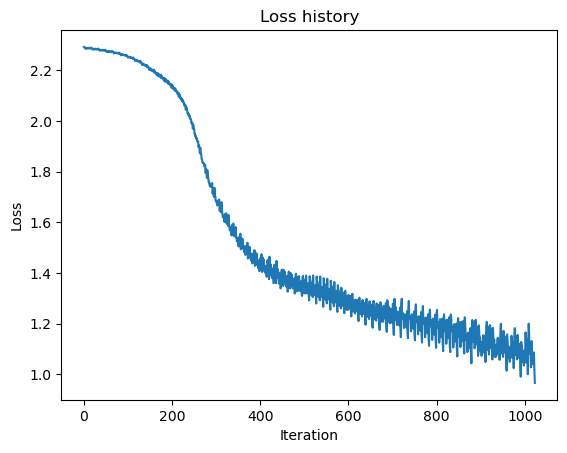

In [10]:
EPOCH_NUM = 64
BATCH_SIZE = 512
if IS_CUDA_AVAILABLE:
    BATCH_SIZE = 2048

# train the model
loss_history = []
for epoch in range(EPOCH_NUM):
    running_loss = 0.0
    for i in tqdm(
            range(0, X_train.shape[0], BATCH_SIZE), 
            # show running loss
            desc=f'Epoch {epoch+1}/{EPOCH_NUM}',
            total=X_train.shape[0]//BATCH_SIZE, 
            # realtime progress bar
            dynamic_ncols=True,
        ):
        # transpose the data to torch tensor
        this_inputs = torch.tensor(X_train[i:i+BATCH_SIZE]).permute(0, 3, 1, 2).float()
        this_labels = torch.tensor(y_train[i:i+BATCH_SIZE]).long()

        if IS_CUDA_AVAILABLE:
            this_inputs = this_inputs.to(DEVICE)
            this_labels = this_labels.to(DEVICE)

        optim.zero_grad()

        outputs = net_CNN(this_inputs)
        loss = crit(outputs, this_labels)
        loss.backward()
        optim.step()

        loss_history.append(loss.item())
        running_loss += loss.item()

    print(f'Epoch {epoch+1} loss: {running_loss / (X_train.shape[0] / BATCH_SIZE)}')

# show history
plt.plot(loss_history)
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()
plt.close()

e:\Anaconda\envs\torch230\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


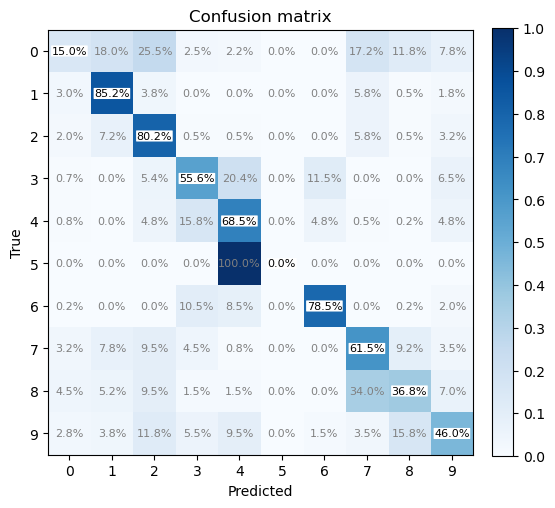

Overall Precision: 0.518, Recall: 0.527, F score: 0.508
   Class  Precision    Recall   F score
0      0   0.468750  0.150000  0.227273
1      1   0.669941  0.852500  0.750275
2      2   0.539496  0.802500  0.645226
3      3   0.487421  0.555556  0.519263
4      4   0.627002  0.685000  0.654719
5      5   0.000000  0.000000  0.000000
6      6   0.846361  0.785000  0.814527
7      7   0.479532  0.615000  0.538883
8      8   0.490000  0.367500  0.420000
9      9   0.571429  0.460000  0.509695


e:\Anaconda\envs\torch230\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
e:\Anaconda\envs\torch230\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


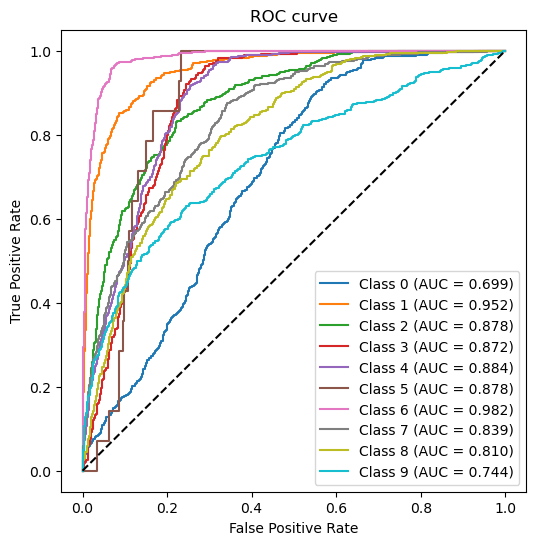

In [12]:
# confusion matrix
from sklearn.metrics import confusion_matrix

with torch.no_grad():
    test_inputs = torch.tensor(X_test).permute(0, 3, 1, 2).float()
    test_labels = torch.tensor(y_test).long()

    if IS_CUDA_AVAILABLE:
        test_inputs = test_inputs.to(DEVICE)
        test_labels = test_labels.to(DEVICE)

    outputs = net_CNN(test_inputs)
    _, predicted = torch.max(outputs, 1)

if IS_CUDA_AVAILABLE:
    y_outputs = outputs.cpu().numpy()
    y_pred = predicted.cpu().numpy()
else:
    y_outputs = outputs.numpy()
    y_pred = predicted.numpy()

confmat = confusion_matrix(y_test, y_pred, labels=range(10), normalize='true')

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
cax = ax.matshow(confmat, cmap='Blues')
# colorbar lim: 0-1
fig.colorbar(cax, fraction=0.046, pad=0.04, ticks=np.arange(0, 1.1, 0.1))
plt.title('Confusion matrix')
for i in range(10):
    for j in range(10):
        plt.text(j, i, f'{confmat[i, j]*100:.1f}%', ha='center', va='center', color='grey', fontsize=8)
plt.xticks(ticks=range(10), labels=range(10))
plt.yticks(ticks=range(10), labels=range(10))
# accuarcy for each label
for i in range(10):
    # text with border
    plt.text(i, i, f'{confmat[i, i]*100:.1f}%', ha='center', va='center', color='k', fontsize=8, bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.05'))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.gca().xaxis.set_ticks_position('bottom')
plt.show()
plt.close()

# precision, recall, F score
from sklearn.metrics import precision_recall_fscore_support
precision, recall, f_score, _ = precision_recall_fscore_support(y_test, y_pred, average='macro')
print(f'Overall Precision: {precision:.3f}, Recall: {recall:.3f}, F score: {f_score:.3f}')

# for each class
precision, recall, f_score, _ = precision_recall_fscore_support(y_test, y_pred, average=None)
df_res = pd.DataFrame({
    'Class': range(10),
    'Precision': precision,
    'Recall': recall,
    'F score': f_score,
})
print(df_res)

# roc curve
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from scipy import interp

y_test_bin = label_binarize(y_test, classes=range(10))
y_outputs_bin = y_outputs
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(10):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_outputs_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
for i in range(10):
    ax.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.3f})')
ax.plot([0, 1], [0, 1], 'k--')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()
plt.close()